# 1 探索数据


数据集使用 kaggle 数据集，解压后存放在images目录下
- 训练数据集路径：
images/all/train
- 测试数据集路径：
images/all/test

# 1.1 整理数据集
 
这里由于 trian 文件夹下的猫和狗的数据是混在一起的，需要将猫和狗的图片分别存储。

图片的命名规则：类别.编码.jpg

**注意：这里的处理只需要运行一次即可**


In [1]:
import os
import shutil
from glob import glob

cutcount = 13

def create_dir(path):
    '''
    创建文件夹
    '''
    if (os.path.exists(path) == False):
        os.mkdir (path)
    else:
        print('文件夹已经存在：%s' % path)

def copy_image_bytype(srcfiles, path):
    '''
    将猫狗文件分别拷贝到不同文件夹下
    '''
    # 限制训练文件数量,0不限制
    limitcount = 0

    filenames = [item[cutcount:] for item in sorted(srcfiles)]
    for src,name in zip(srcfiles,filenames):
        
        dst = path + '/' + name
        if (os.path.exists(dst) == False):
            shutil.copyfile(src, dst)

        # 跳出循环
        limitcount = limitcount - 1
        if (limitcount == 0):
            break
            

In [2]:
# 创建文件夹
train_path = 'images/all/trainnew'
dog_path = 'images/all/trainnew/dogs'
cat_path = 'images/all/trainnew/cats'

create_dir(train_path)
create_dir(dog_path)
create_dir(cat_path)


文件夹已经存在：images/all/trainnew
文件夹已经存在：images/all/trainnew/dogs
文件夹已经存在：images/all/trainnew/cats


In [3]:
# 处理狗
dogs_list = glob("images/train/dog.*")

# 打印数据统计描述
# print(dogs_list[0])
dog_filenames = [item[cutcount:] for item in sorted(dogs_list)]
print('There are %d total dog categories.' % len(dogs_list))

# 整理狗数据
copy_image_bytype(dogs_list, dog_path)


There are 12500 total dog categories.


In [4]:
# 处理猫
cats_list = glob("images/train/cat.*")

# 打印数据统计描述
cat_filenames = [item[cutcount:] for item in sorted(cats_list)]
print('There are %d total cat categories.' % len(cat_filenames))

# 整理猫数据
copy_image_bytype(cats_list, cat_path)


There are 12500 total cat categories.


## 1.2 导入数据

In [5]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np


Using Theano backend.


### 1.2.1 加载 train 数据集

In [6]:
# 加载 train 测试数据集
train_data = load_files(train_path)
trainall_file = np.array(train_data['filenames'])
trainall_targets = np_utils.to_categorical(np.array(train_data['target']), 2)
# print(type(train_data))
# print(train_targets)

# 展示训练数据集
print('训练集数据总数：%d' % len(trainall_file))


训练集数据总数：25000


### 1.2.2 加载 test 数据集

In [7]:
# 加载 test 测试数据集
test_path = 'images/all/testnew'
test_data = load_files(test_path)
test_files = np.array(test_data['filenames'])
test_targets = np_utils.to_categorical(np.array(test_data['target']), 1)

# 展示测试数据集
print('测试集数据总数：%d' % len(test_files))

测试集数据总数：12500


## 1.3 数据可视化

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import mode as spmode

def draw_hist(mylist, title, xlabel, ylabel, xmin, xmax, ymin, ymax):
    '''
    绘制直方图，参数依次为list,抬头,X轴标签,Y轴标签,XY轴的范围
    '''
    plt.hist(mylist, 100)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(title)
    plt.show()

def show_filesize(paths):
    filesizes = []
    for path in paths:
        filesize = os.path.getsize(path)
        filesizes.append(filesize)
    
    title = 'file size distribute'
    xlabel = 'file size'
    ylabel = 'file count'
    xmin = np.min(filesizes)
    xmax = np.max(filesizes)
    ymin = 0
    ymax = 1200

    # train 中文件的的最小值、最大值、中位数、众数
    train_min = np.min(filesizes)
    print('train 中文件的的最小值:', train_min)

    train_max = np.max(filesizes)
    print('train 中文件的的最大值:', train_max)

    train_median = np.median(filesizes)
    print('train 中文件的的中位数:', train_median)

    train_mode = spmode(filesizes)
    print('train 中文件的的众数:', train_mode)

    draw_hist(filesizes, title, xlabel, ylabel, xmin, xmax, ymin, ymax)



train 中文件的的最小值: 1106
train 中文件的的最大值: 93323
train 中文件的的中位数: 22165.5
train 中文件的的众数: ModeResult(mode=array([20918]), count=array([6]))


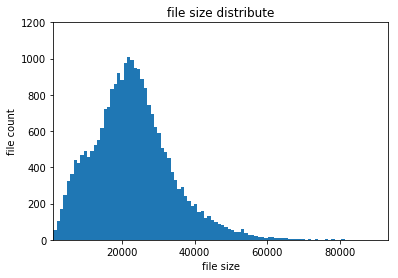

In [9]:
# 文件大小的分布
show_filesize(trainall_file)        


## 1.4 数据预处理

### 1.4.1 分割训练集

In [10]:
from sklearn.model_selection import train_test_split

# 将原来的训练数据分割成训练数据集和验证数据集，比例为20%
train_files, valid_files, train_targets, valid_targets = train_test_split(trainall_file, trainall_targets, test_size=0.3)

print(len(train_files))
print(len(valid_files))
# print(tarin_targets)
# print(valid_targets)

17500
7500


### 1.4.1 图像预处理

通过对每张图像的像素值除以299，我们对图像实现了归一化处理

In [12]:
from keras.preprocessing import image
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

def path_to_tensor(img_path):
#     print(img_path)
    # 用PIL加载RGB图像为PIL.Image.Image类型
    img = image.load_img(img_path,target_size=(299,299))
    
    #将PIL.Image.Image类型转化为格式为(299,299,3)的3维张量
    x = image.img_to_array(img)
    
    #将3维张量转化为格式为(1, 299, 299, 3) 的4维张量并返回
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

# img_path='images/all/train/trainnew/cats/cat.4424.jpg'
# path_to_tensor(img_path)




In [15]:
# 训练集预处理
train_tensors = paths_to_tensor(train_files).astype('float32')/127.5 - 1


100%|██████████| 17500/17500 [00:58<00:00, 297.61it/s]


MemoryError: 

In [14]:
# 验证集预处理
valid_tensors = paths_to_tensor(valid_files).astype('float32')/127.5 - 1


100%|██████████| 7500/7500 [00:21<00:00, 342.97it/s]


In [13]:
# 测试集预处理
test_tensors = paths_to_tensor(test_files).astype('float32')/127.5 - 1


100%|██████████| 12500/12500 [00:41<00:00, 300.98it/s]


# 2 构建模型



## 2.1 训练模型

训练 InceptionV3 模型

In [17]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.optimizers import SGD

# 1.构建不带分类器的预训练模型
base_model = InceptionV3(weights='imagenet', include_top=False)


OSError: [Errno 12] Cannot allocate memory

In [ ]:
# 2.添加全局平均池化层
x = base_model.output
x = GlobalAveragePooling2D()(x)


In [ ]:
# 3.全连接层，可选，如果精度够用则可以不加
# x = Dense(1024, activation='relu')(x)


In [ ]:
# 4. 添加一个分类器，使用 1 个神经元，sigmoid激活函数
predictions = Dense(2, activation='sigmoid')(x)


In [ ]:
# 5. 构建我们需要训练的完整模型
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# 6.首先只训练顶部的几层（随机初始化的层），锁住所有 InceptionV3d 卷积层
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
# 7.编译模型（一定要在锁层以后操作）
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')


In [ ]:
# 8. 在新的数据集上训练几代
# model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
#          epochs=20, batch_size=20, verbose=0)
model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
         epochs=3, batch_size=5, verbose=0)


In [ ]:
# 9.现在顶层应该训练好了，开始微调 InceptionV3的卷积层。
#锁住底下的几层，然后训练其余的顶层。查看每一层的名字和层号，看看应该锁多少层
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)
 

In [ ]:
# 10.我们选择训练最上面的两个 Inception block, 锁住前面249层，然后放开之后的层
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True


In [ ]:
# 11.重新编译模型，使上面的修改生效，设置一个很低的学习率，使用SGD来微调
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
# 12.继续训练模型，训练最后两个 Inception block 和两个全连接层
Inceptionfile_hdf5 ='saved_models/weights.best.Inception.hdf5'

# 模型保存
checkpointer = ModelCheckpoint(filepath=Inceptionfile_hdf5, verbose=1, save_best_only=True)

# 可视化
tensorboard = TensorBoard(log_dir='log')

callback_lists = [tensorboard, checkpointer]

# 训练模型
history_callback = model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
         epochs=20, batch_size=20,callbacks=callback_lists,shuffle='True',verbose='True')


## 2.2 测试模型

在测试数据集上试用训练后的模型

In [ ]:
## 加载具有最好验证loss的模型
model.load_weights(Inceptionfile_hdf5)

# 获取测试数据集中每一个图像所预测的狗品种的index
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# 报告测试准确率
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

loss_history = history_callback.history['loss']
print(loss_history)

# 猫狗大战

## 注意：请不要直接使用网上公开的代码

[Dogs vs. Cats Redux: Kernels Edition
](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

![](dogvscat.png)

## AWS

由于此项目要求的计算量较大，建议使用亚马逊 p3.2xlarge 云服务器来完成该项目，在使用 p3 之前，你可以先用 p2.xlarge 练手，参考：[在aws上配置深度学习主机 ](https://zhuanlan.zhihu.com/p/25066187)，[利用AWS学习深度学习](https://zhuanlan.zhihu.com/p/33176260)。

## 描述

使用深度学习方法识别一张图片是猫还是狗。

* 输入：一张彩色图片
* 输出：狗的概率

## 数据

此数据集可以从 kaggle 上下载。[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)

此外还有一个数据集也非常好，可以作为扩充数据集或是做检测/分割问题：[The Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/)

![](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

## 建议

建议使用 OpenCV, tensorflow, Keras 完成该项目。其他的工具也可以尝试，比如 caffe, mxnet 等。

* [OpenCV](https://github.com/opencv/opencv)
* [OpenCV python tutorials](http://docs.opencv.org/3.1.0/d6/d00/tutorial_py_root.html)
* [tensorflow](https://github.com/tensorflow/tensorflow)
* [Keras](https://github.com/fchollet/keras)
* [Keras 中文文档](http://keras-cn.readthedocs.io/)

### 建议模型

如果你不知道如何去构建你的模型，可以尝试以下的模型，后面的数字代表年份和月份：

* [VGGNet](https://arxiv.org/abs/1409.1556) 14.09
* [ResNet](https://arxiv.org/abs/1512.03385) 15.12
* [Inception v3](https://arxiv.org/abs/1512.00567) 15.12
* [InceptionResNetV2](https://arxiv.org/abs/1602.07261) 16.02
* [DenseNet](https://arxiv.org/abs/1608.06993) 16.08
* [Xception](https://arxiv.org/abs/1610.02357) 16.10
* [NASNet](https://arxiv.org/abs/1707.07012) 17.07

参考 Keras 文档：[Documentation for individual models](https://keras.io/applications/#documentation-for-individual-models)

# 最低要求

本项目的最低要求是 kaggle Public Leaderboard 前10%。

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/leaderboard

## 应用(可选)(推荐)

应用形式多种多样，可以是在本地调用摄像头跑的程序，也可以网页的，也可以是 iOS APP 或 Android APP，甚至可以是微信公众号。

### 网页应用

推荐的工具：

* [Flask](https://github.com/pallets/flask)
* [Flask 中文文档](http://docs.jinkan.org/docs/flask/)

### 微信公众号

可以参考这个例子：[微信数字识别](https://github.com/ypwhs/wechat_digit_recognition)。

网页接口部分可以参考 [Flask](https://github.com/pallets/flask) 而不必用 python cgi。

### iOS

如果你使用 Keras 完成该项目，可以直接使用 Apple 提供的 [Core ML Tools](https://developer.apple.com/documentation/coreml/converting_trained_models_to_core_ml) 把训练出来的 Keras 模型直接转为 iOS 可以使用的模型。

当然在 iOS 平台上你也可以使用 [MetalPerformanceShaders](https://developer.apple.com/reference/metalperformanceshaders) 来实现卷积神经网络。

这里有一个 [Inception v3](https://github.com/shu223/iOS-10-Sampler/blob/master/iOS-10-Sampler/Samples/Inception3Net.swift) 在 iOS 上跑的例子，你可以参考，不过我们还是建议直接用上面的工具将 Keras 的模型转为 iOS 直接可以使用的模型。

![](https://raw.githubusercontent.com/shu223/iOS-10-Sampler/master/README_resources/imagerecog.gif)

OpenCV 的 iOS Framework 文件可以直接在这里下载：[OpenCV releases](https://github.com/opencv/opencv/releases)。这里有一份教程，可以轻松入门：[turorial_hello](https://docs.opencv.org/master/d7/d88/tutorial_hello.html)

最终效果可以参考这个 app ：[PetOrNot](https://itunes.apple.com/cn/app/petornot/id926645155)

![PetOrNot](PetOrNot.jpeg)

### Android

在 Android 上运行 tensorflow 可以参考 [android tensorflow](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android)。

在 Android 上运行 OpenCV 可以参考 [OpenCV4Android SDK](http://docs.opencv.org/master/da/d2a/tutorial_O4A_SDK.html)。

## 评估

你的项目会由优达学城项目评审师依照[机器学习毕业项目要求](https://review.udacity.com/#!/rubrics/273/view)来评审。请确定你已完整的读过了这个要求，并在提交前对照检查过了你的项目。提交项目必须满足所有要求中每一项才能算作项目通过。

## 提交

* PDF 报告文件
* 数据预处理代码（jupyter notebook）
* 模型训练代码（jupyter notebook）
* notebook 导出的 html 文件
* 应用代码（可选）
* 包含使用的库，机器硬件，机器操作系统，训练时间等数据的 README 文档（建议使用 Markdown ）
